Małgorzata Gierdewicz id: 148264

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For this project I initially wanted to train Haar classifier to find dices, however it wasn't accurate at all, so after many attempts I decided to use the wery simple techniques such as finding a square for detection of board and finding a large enough white area for the detection of dice. On the easy and medium level short movies the detection of board goes fine, however there can be problems with detection of the dice on the medium level movie since more than one region on image can be classified as white region. On the hard movie there is no problem with detecting the dice, however the regular method for detecting the board in my project don't work there.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random
from google.colab.patches import cv2_imshow
from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

In [18]:
path_video_easy_1 = '/content/drive/MyDrive/Cv2/easy_redo/IMG_6061.MOV'
path_video_easy_2 = '/content/drive/MyDrive/Cv2/easy_redo/IMG_6062.MOV'
path_video_easy_3 = '/content/drive/MyDrive/Cv2/easy_redo/IMG_6063.MOV'

In [19]:
def imshow(a):
    a = a.clip(0, 255).astype("uint8")
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(a))

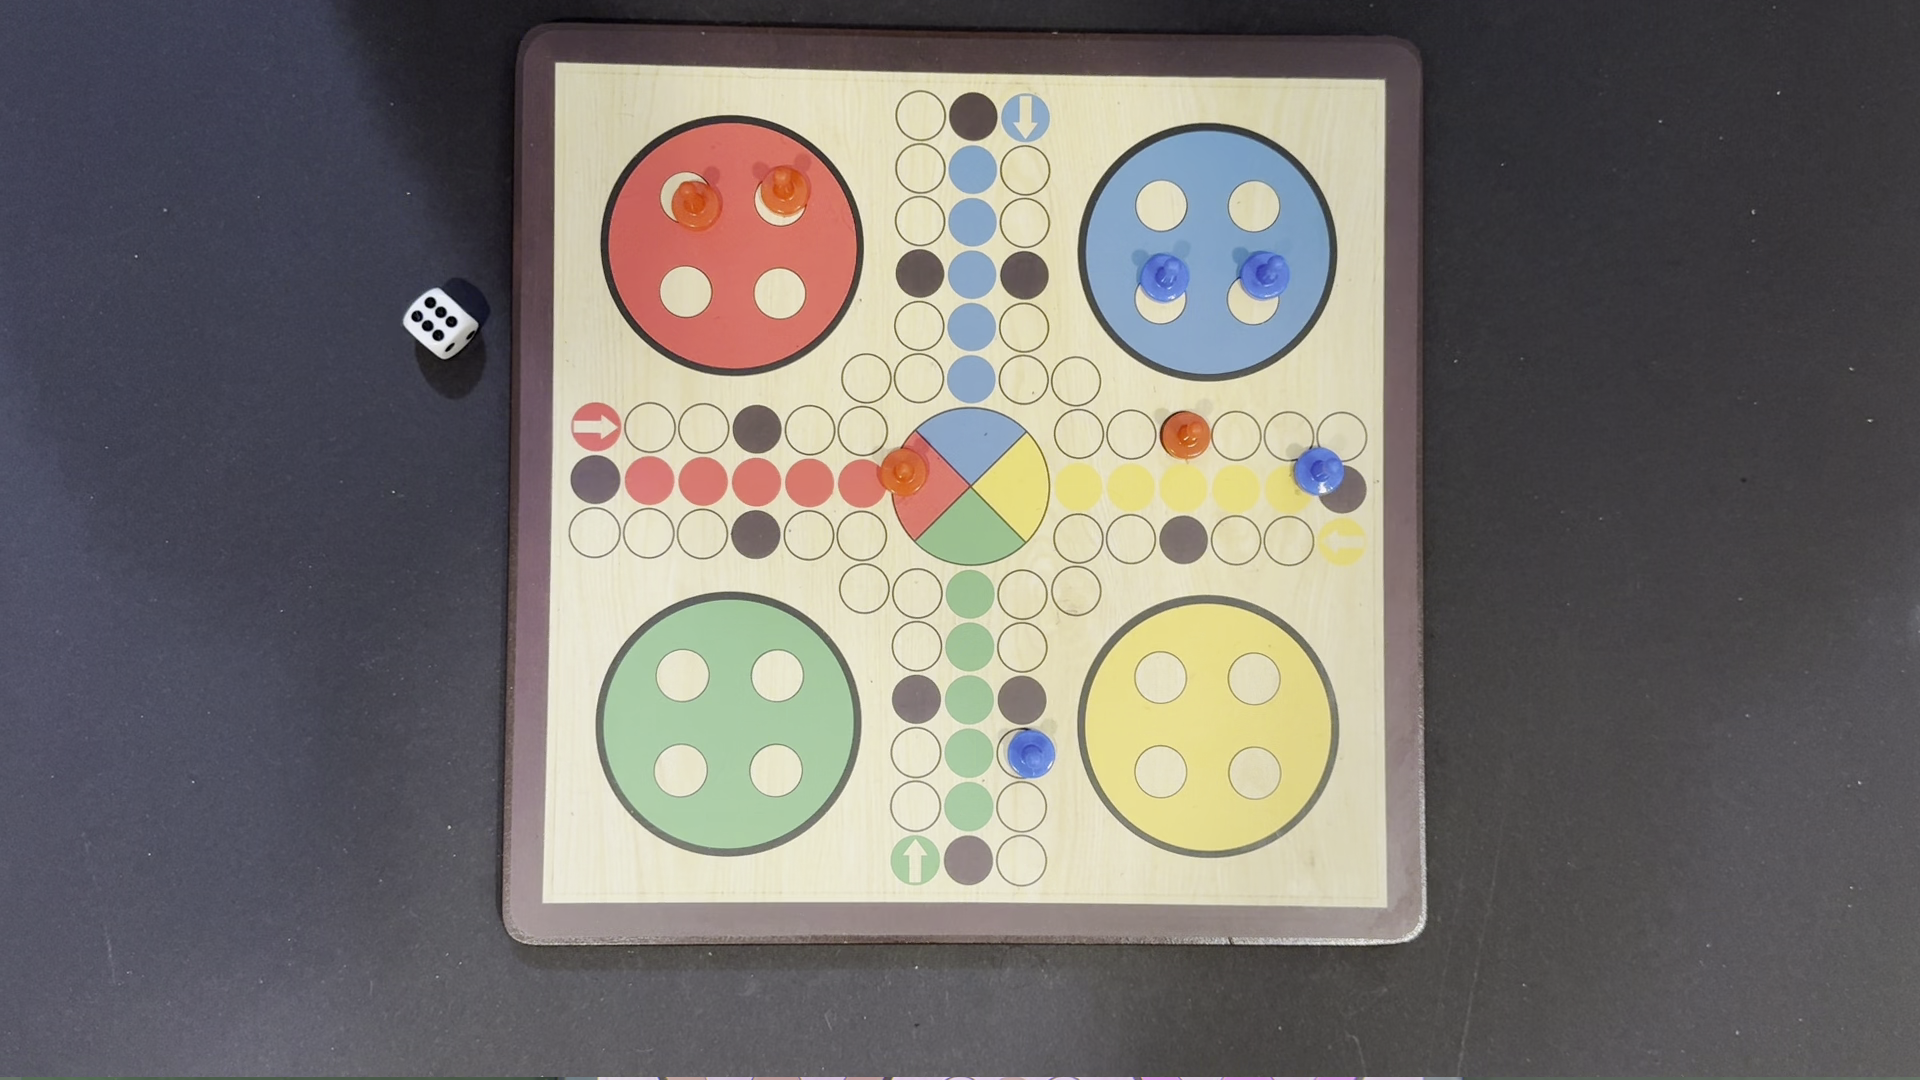

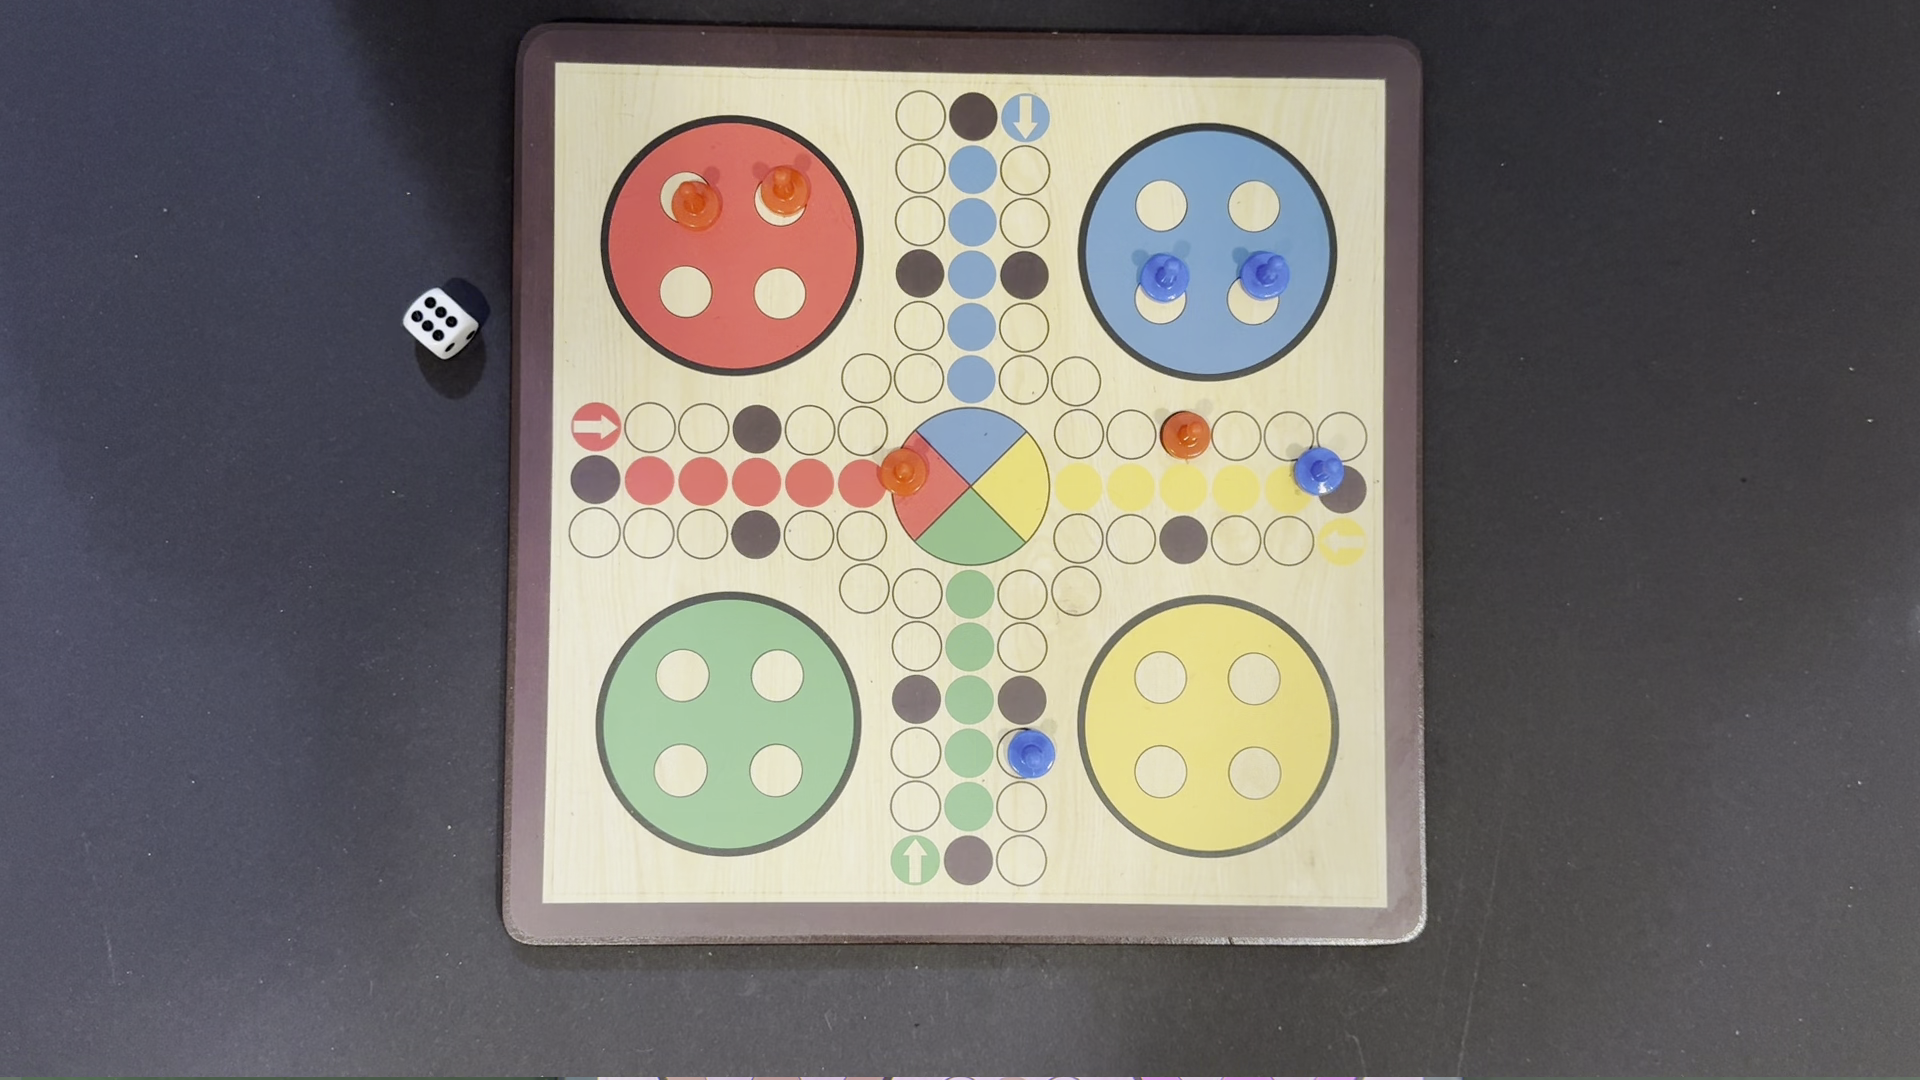

In [66]:
import cv2
from google.colab.patches import cv2_imshow

capture = cv2.VideoCapture(path_video_easy_3)

frameNr = 0
frames = []

success, frame = capture.read()

while (True):
    if frameNr == 300:
      cv2_imshow(frame)
      cv2.imwrite("frame%d.jpg" % frameNr, frame)
      frames.append(frame)
      imshow(frame)
      break
    success, frame = capture.read()

    if success:
        pass

    else:
        break

    frameNr = frameNr+1

capture.release()

In [67]:
from google.colab.patches import cv2_imshow

In [68]:
cv2.imread('frame300.jpg').shape

(1080, 1920, 3)

In [129]:
import cv2
import numpy as np

def detect_squares(image_path):

    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return []


    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 100, 350)
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    squares = []

    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            if 0.9 <= aspect_ratio <= 1.1:
                squares.append(approx)

    return squares

In [143]:
import cv2
import numpy as np

def detect_dice(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_area = 800
    max_area = 4000

    x, y, w, h = None, None, None, None

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area and area <= max_area:
            x, y, w, h = cv2.boundingRect(contour)
            x = max(0, x)
            y = max(0, y)
            w = min(w, image.shape[1] - x)
            h = min(h, image.shape[0] - y)

            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            break

    cv2.imwrite('output_image.jpg', image)

    if x is not None:
        return (x, y, w, h)
    else:
        return None



In [26]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.legacy.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.legacy.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.legacy.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.legacy.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.legacy.TrackerCSRT_create()

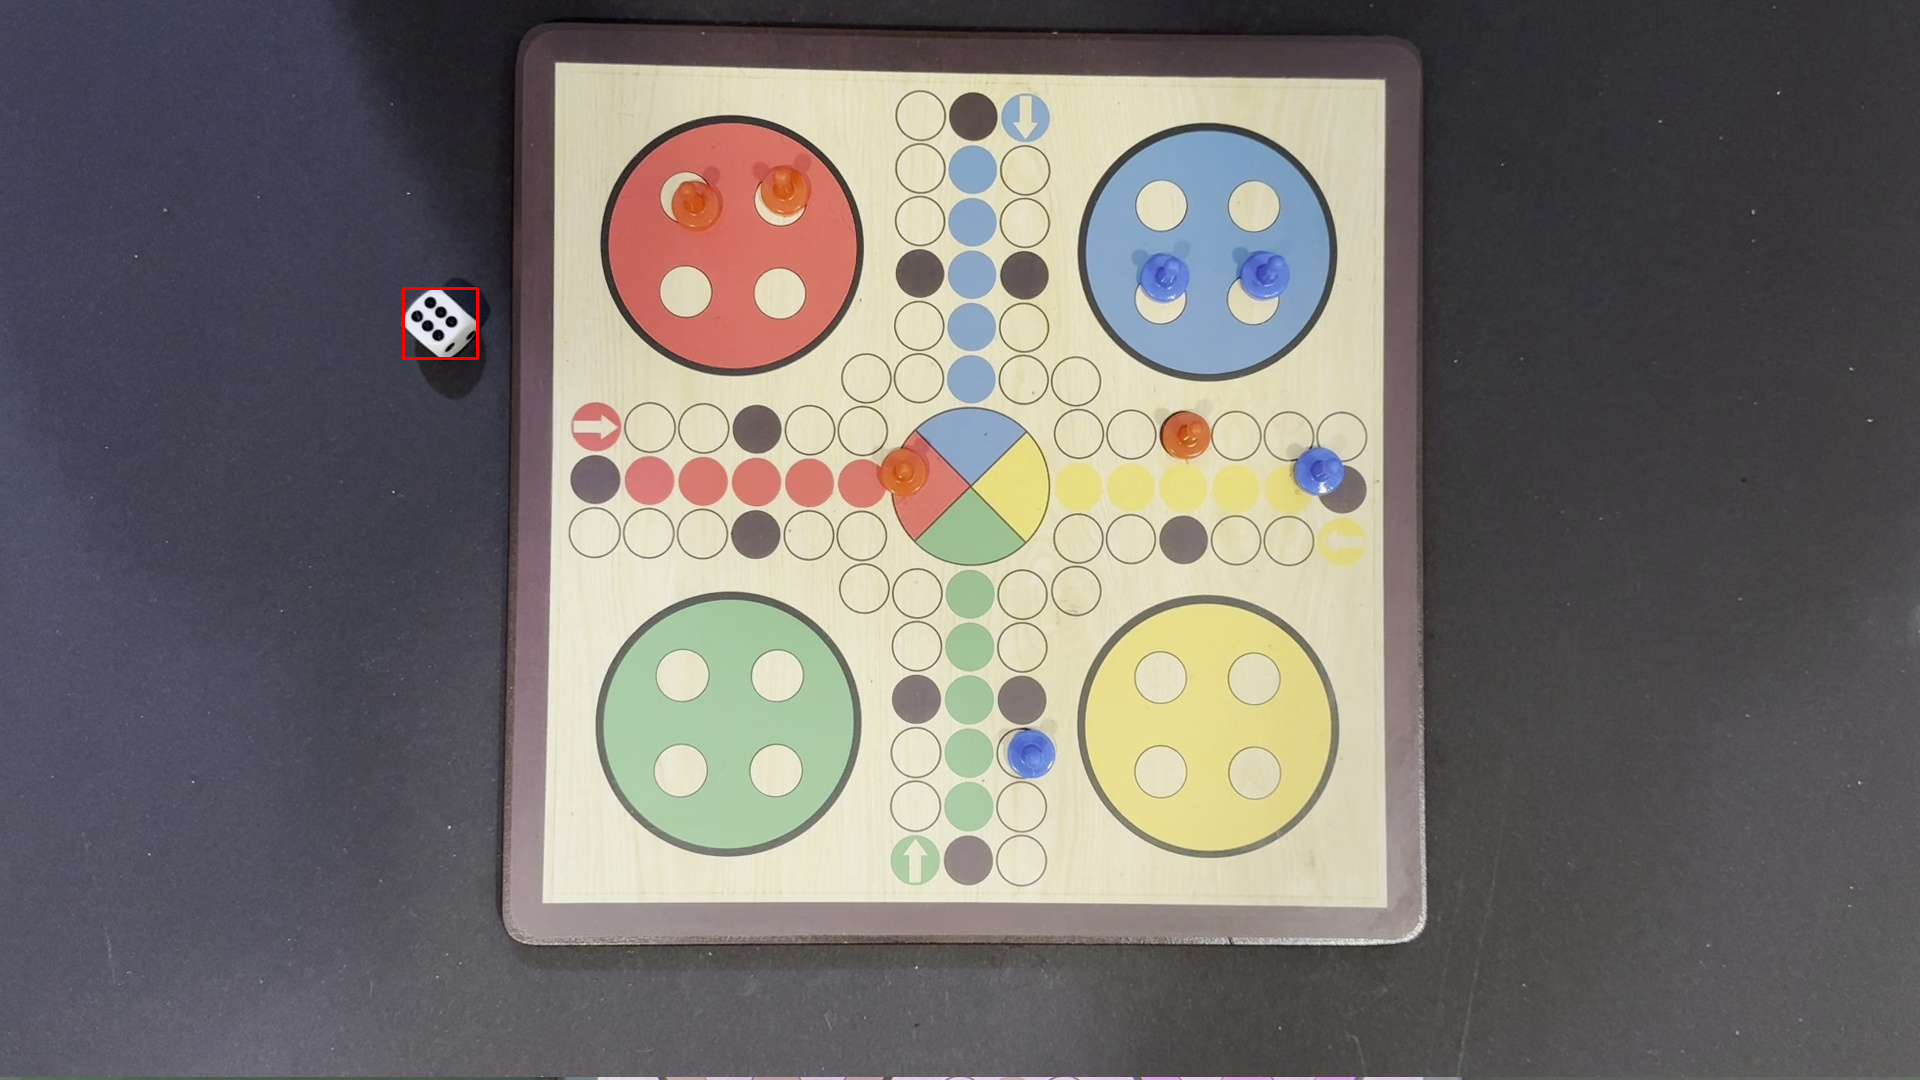

(403, 288, 74, 70)

In [82]:
detect_dice('frame300.jpg')


In [141]:
def main():
    video_path = '/content/drive/MyDrive/Cv2/hard_redo/IMG_6066.MOV'
    initial_frame_number = 0

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video")
        return

    cap.set(cv2.CAP_PROP_POS_FRAMES, initial_frame_number)
    ret, initial_frame = cap.read()
    if not ret:
        print("Error reading initial frame")
        return
    cv2.imwrite('temp_initial_frame.jpg', initial_frame)

    squares = detect_squares('temp_initial_frame.jpg')
    dice_bboxes = detect_dice('temp_initial_frame.jpg')

    if dice_bboxes is None or len(dice_bboxes) == 0:
        print("No dice detected in the initial frame.")
        return

    dice_bbox = dice_bboxes


    tracker = create_tracker("CSRT")
    if not tracker.init(initial_frame, dice_bbox):
        print("Tracker initialization failed")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    output_path = 'output_tracking_hard.avi'
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (frame_width, frame_height))

    cap.set(cv2.CAP_PROP_POS_FRAMES, initial_frame_number)
    tracker_val = 1
    frame_count = 0
    while True:
            ret, frame = cap.read()
            if not ret:
                break

            ok, bbox = tracker.update(frame)

            if not ok:
                print("Dice lost. Attempting to re-detect...")
                temp_frame_path = f'temp_frame_{frame_count}.jpg'
                cv2.imwrite(temp_frame_path, frame)
                if detect_dice(temp_frame_path) is None:
                    print("No dice detected in the current frame.")
                    continue
                dice_bboxes = detect_dice(temp_frame_path)
                if dice_bboxes:
                    dice_bbox = dice_bboxes
                    tracker = create_tracker("CSRT")
                    if not tracker.init(frame, dice_bbox):
                        print("Tracker re-initialization failed")
                        continue
                    print("Tracker re-initialized successfully.")
                    ok = True

            temp_frame_path = f'temp_frame_{frame_count}.jpg'
            cv2.imwrite(temp_frame_path, frame)

            if detect_squares(temp_frame_path) is not None:
                squares = detect_squares(temp_frame_path)
                # Check if squares is a valid list of contours and not empty
                if squares is not None and len(squares):
                    # Check if any contour has at least one point
                    if any(len(contour) > 0 for contour in squares):
                        cv2.drawContours(frame, squares, -1, (0, 255, 0), 3)
                    else:
                        print("Contours found, but they are empty.")
                else:
                    print("No squares detected in this frame.")

            if ok:
                x, y, w, h = [int(v) for v in bbox]
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)

            out.write(frame)
            frame_count+=1

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [131]:
if __name__ == "__main__":
    main()

No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected 

In [135]:
if __name__ == "__main__":
    main()

No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected 

In [142]:
if __name__ == "__main__":
    main()

No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected in this frame.
No squares detected 